In [23]:
import json
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline
import seaborn as sns
import datetime

In [24]:
matplotlib.rcParams['figure.dpi']= 300
sns.set(style="ticks", font_scale=1.0)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman'
})

In [25]:
def get_data():
    with open("raw_results.json") as f:
        result = json.load(f)
        
    def parse_task(task):
        splitted = task.split("-")
        
        n_trajectories = splitted[-1]
        policy_level   = splitted[-2]
        env_name      = "-".join(splitted[:-2])
        if env_name == "finance":
            env_name = "finrl"
        elif env_name == "ib":
            env_name = "industrial"
        
        return env_name, policy_level, n_trajectories
        
    parsed_data = []
    for task_name, algs in result.items():
        env, level, n_traj = parse_task(task_name)
        for alg_name, experiments in algs.items():
            for experiment in experiments:
                params  = experiment["parameter"]
                results = experiment["result"]

                for seed, evaluations in results.items():
                    parsed_data.append({
                        "env": env,
                        "policy_level": level,
                        "n_trajectories": int(n_traj),
                        "alg": alg_name,
                        "seed": seed,
                        "perf/online": evaluations["online"],
                        "perf/val_vs0_fqe": evaluations["fqe"]["7"]
                    })
    return pd.DataFrame(parsed_data)

def normalize_performance(df):
    BASELINE_PERFORMANCES = {
        "finrl_low": 152,
        "finrl_medium": 357,
        "finrl_high": 419,

        "industrial_low": -344311,
        "industrial_medium": -283121,
        "industrial_high": -220156,

        "citylearn_low": 29514,
        "citylearn_medium": 36900,
        "citylearn_high": 48818,
        
        "HalfCheetah-v3_high": 7836,
        "HalfCheetah-v3_medium": 5568,
        "HalfCheetah-v3_low": 2871,
        
        "Hopper-v3_high": 1551,
        "Hopper-v3_medium": 1410,
        "Hopper-v3_low": 498,
        
        "Walker2d-v3_high": 2936,
        "Walker2d-v3_medium": 2221,
        "Walker2d-v3_low": 1278,
    }
    
    for ind, row in df.iterrows():
        for column in ["eop_mean", "eop_max", "eop_min"]:
            rpc = row[column] - BASELINE_PERFORMANCES[f'{row["env"]}_{row["policy_level"]}']
            rel_performance = 1.0 + (rpc / abs(BASELINE_PERFORMANCES[f'{row["env"]}_{row["policy_level"]}']))
            df.loc[ind, column] = rel_performance
            
        # Different for std
        rel_performance = abs(row["eop_std"] / BASELINE_PERFORMANCES[f'{row["env"]}_{row["policy_level"]}'])
        df.loc[ind, "eop_std"] = rel_performance
    return df

In [26]:
results = get_data()

In [27]:
results.alg.unique()

array(['bc', 'bcq', 'plas', 'crr', 'cql', 'mopo', 'bremen'], dtype=object)

In [28]:
from scipy.stats import iqr as scipy_iqr
from eop.core import expected_online_performance_arbit, expected_online_performance

lower_bound_trials_per_seed = 10
total_seeds = 3

# Arbitrary selection methods
exp_keys    = ["seed", "env", "policy_level", "n_trajectories", "alg"]
eop_keys    = ["eop_ind", "eop_mean", "eop_std", "eop_max", "eop_min", "ops_name"]
grouped_res = results.groupby(exp_keys)
arbit_experiments = []
for experiment, datapoints in grouped_res:
    eop_methods = ["val_vs0_fqe"]
    for eop_m in eop_methods:
        eop = expected_online_performance_arbit(datapoints["perf/online"], datapoints[f"perf/{eop_m}"].dropna(), lower_bound_trials_per_seed)
        if len(eop["mean"]) < lower_bound_trials_per_seed:
            continue

        for order_stat_i in range(len(eop["mean"])):
            arbit_experiments.append(experiment + (order_stat_i, eop["mean"][order_stat_i], eop["mean"][order_stat_i], eop["max"], eop["min"], eop_m))          
arbit_experiments = pd.DataFrame(arbit_experiments, columns=exp_keys+eop_keys)
arbit_experiments = arbit_experiments.groupby(["env", "policy_level", "n_trajectories", "alg", "ops_name", "eop_ind"]).agg({
    "eop_mean": "mean",
    "eop_std": "std",
    "eop_max": "max",
    "eop_min": "min"
}).reset_index()

# Uniform Selection method
exp_keys = ["env", "policy_level", "n_trajectories", "alg"]
grouped_res = results.groupby(exp_keys)
us_experiments = []
for experiment, datapoints in grouped_res:
    eop = expected_online_performance(datapoints["perf/online"], lower_bound_trials_per_seed * total_seeds)
#     if len(eop["mean"]) < lower_bound_trials_per_seed * total_seeds:
#         continue
            
    for order_stat_i in range(len(eop["mean"])):
        us_experiments.append(experiment + (order_stat_i, eop["mean"][order_stat_i], eop["std"][order_stat_i], eop["max"], eop["min"], "uniform"))
us_experiments = pd.DataFrame(us_experiments, columns=exp_keys+eop_keys)

all_experiments = pd.concat([us_experiments, arbit_experiments], ignore_index=True)
# all_experiments = normalize_performance(all_experiments)

In [34]:
pd.set_option('display.max_rows', 500)
all_experiments[(all_experiments.env == "Hopper-v3") & (all_experiments.policy_level == "medium") & (all_experiments.n_trajectories == 10000)].head(200)



,env,policy_level,n_trajectories,alg,eop_ind,eop_mean,eop_std,eop_max,eop_min,ops_name
1938,Hopper-v3,medium,10000,bc,0,1794.112623,486.349890,2345.959154,1162.656831,uniform
1939,Hopper-v3,medium,10000,bc,1,2057.068695,382.696460,2345.959154,1162.656831,uniform
1940,Hopper-v3,medium,10000,bc,2,2179.701257,286.416885,2345.959154,1162.656831,uniform
1941,Hopper-v3,medium,10000,bcq,0,1325.366263,505.253798,2220.853106,314.400465,uniform
1942,Hopper-v3,medium,10000,bcq,1,1605.629733,406.172247,2220.853106,314.400465,uniform
1943,Hopper-v3,medium,10000,bcq,2,1742.301083,348.586020,2220.853106,314.400465,uniform
1944,Hopper-v3,medium,10000,bcq,3,1826.349824,308.895357,2220.853106,314.400465,uniform
1945,Hopper-v3,medium,10000,bcq,4,1883.861126,281.718416,2220.853106,314.400465,uniform
1946,Hopper-v3,medium,10000,bcq,5,1926.236281,263.527355,2220.853106,314.400465,uniform
1947,Hopper-v3,medium,10000,bcq,6,1959.345254,251.116225,2220.853106,314.400465,uniform


In [7]:
all_experiments.env.unique()

array(['HalfCheetah-v3', 'Hopper-v3', 'Walker2d-v3', 'citylearn', 'finrl',
       'industrial'], dtype=object)

In [10]:
all_experiments

,env,policy_level,n_trajectories,alg,eop_ind,eop_mean,eop_std,eop_max,eop_min,ops_name
0,HalfCheetah-v3,high,100,bc,0,0.720392,0.511293,1.084309,-0.002681,uniform
1,HalfCheetah-v3,high,100,bc,1,0.961945,0.341054,1.084309,-0.002681,uniform
2,HalfCheetah-v3,high,100,bc,2,1.042816,0.205049,1.084309,-0.002681,uniform
3,HalfCheetah-v3,high,100,bcq,0,0.570777,0.334427,0.954623,0.018101,uniform
4,HalfCheetah-v3,high,100,bcq,1,0.752303,0.224892,0.954623,0.018101,uniform
...,...,...,...,...,...,...,...,...,...,...
6829,industrial,medium,10000,mopo,5,0.649853,0.149152,0.864540,-7.392529,val_vs0_fqe
6830,industrial,medium,10000,mopo,6,0.649853,0.149152,0.864540,-7.392529,val_vs0_fqe
6831,industrial,medium,10000,mopo,7,0.664438,0.174250,0.864540,-7.392529,val_vs0_fqe
6832,industrial,medium,10000,mopo,8,0.664438,0.174250,0.864540,-7.392529,val_vs0_fqe


In [8]:
all_experiments.alg.unique()

array(['bc', 'bcq', 'bremen', 'cql', 'crr', 'mopo', 'plas'], dtype=object)

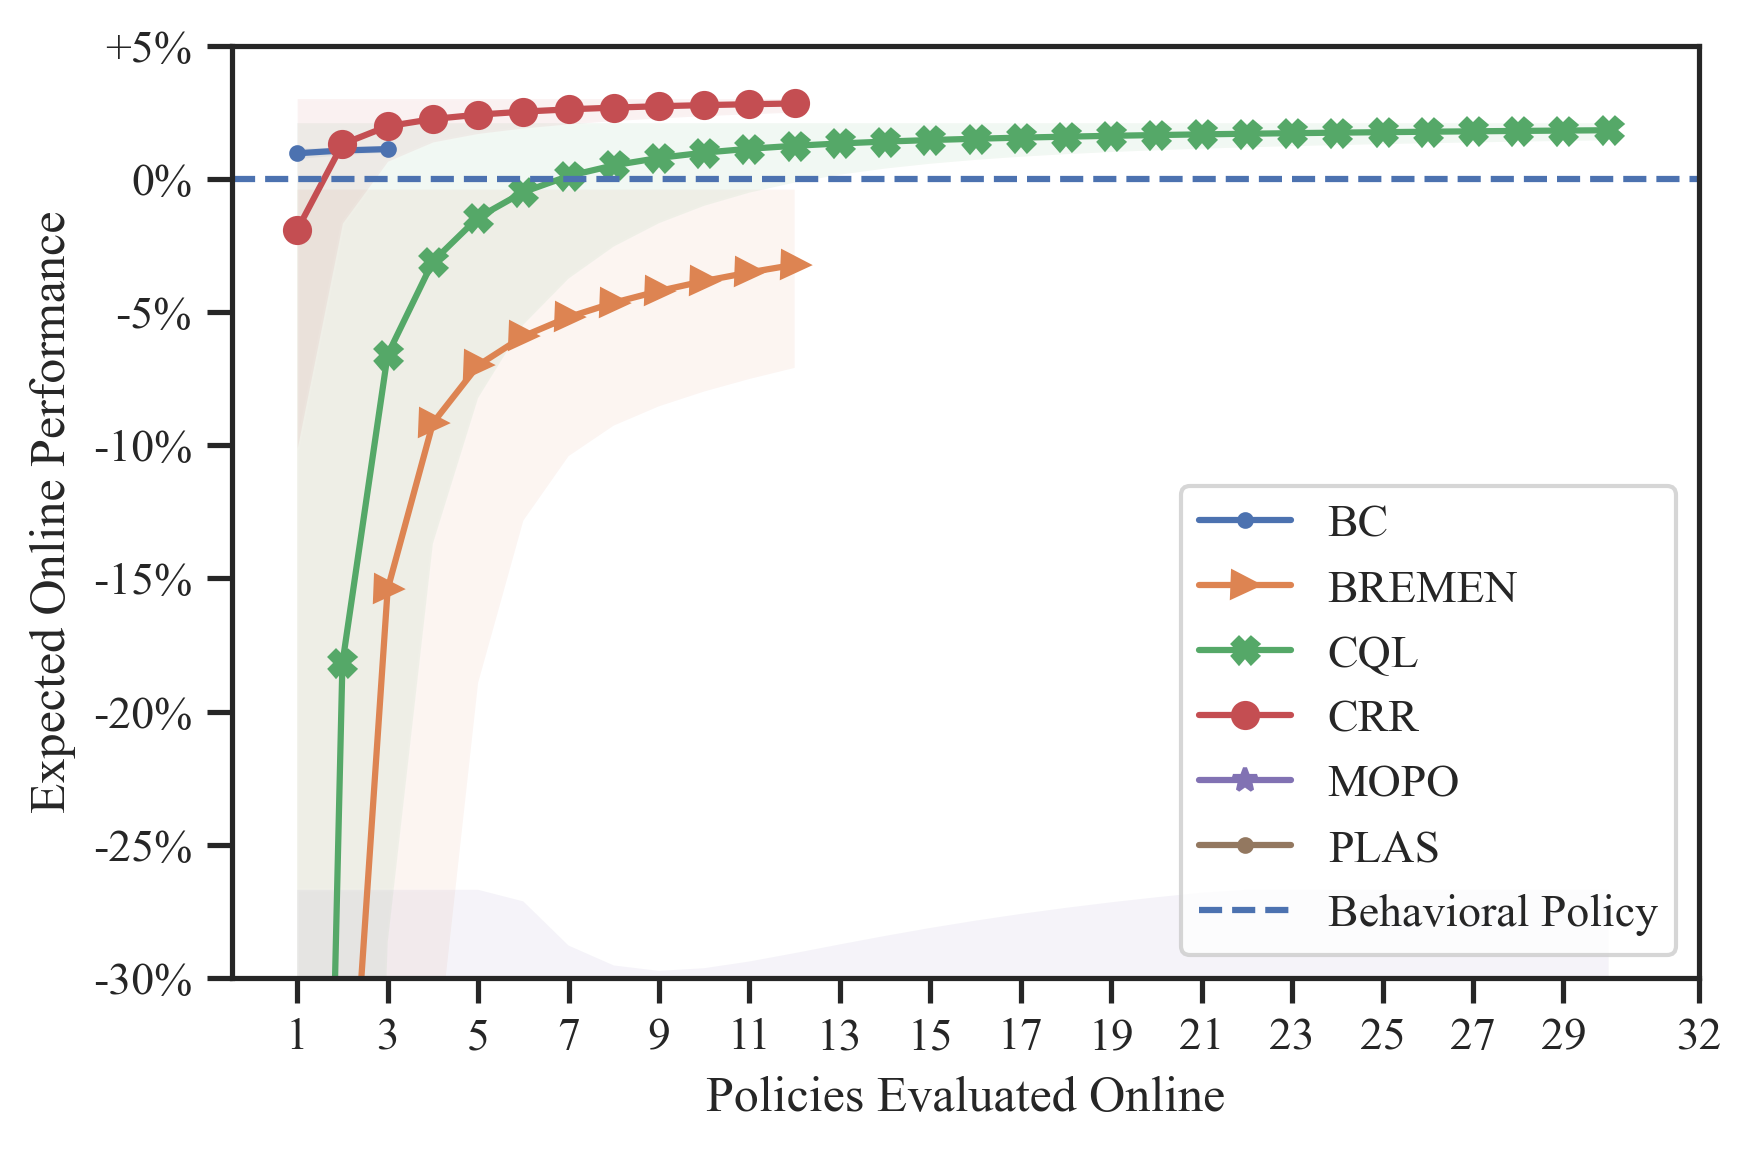

In [17]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 32
def cur_mask():
    return (all_experiments.policy_level == "medium") & (all_experiments.n_trajectories == 1000) & (all_experiments.ops_name == "uniform") & (all_experiments.env == "industrial") & (all_experiments.alg.isin(["cql", "mopo", "bc", "crr", "mopo", "plas", "bremen"]))
explore_experiments = all_experiments[cur_mask()]

# Draw
h3_grid = explore_experiments.groupby(["alg", "eop_ind"]).agg({
    "eop_mean": "mean",
    "eop_std": "mean",
    "eop_max": "max",
    "eop_min": "min"
})
# to set default values
marker         = cycle(('.', '>', 'X', 'o', '*')) 
linewidth      = 1.5
errorbar_kind  = "shade"
errorbar_alpha = 0.08
fontsize       = 12

_, cur_ax = plt.subplots(1,1)
cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

for n_trajectories, datapoints in h3_grid.groupby(["alg"]):
    means = datapoints["eop_mean"][:TARGET_TRIALS]
    vars  = datapoints["eop_std"][:TARGET_TRIALS]
    max_acc = max(datapoints["eop_max"])
    min_acc = min(datapoints["eop_min"])
    x_axis = [i+1 for i in range(len(means))]
    if True:
        if errorbar_kind == 'shade':
            minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
            plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
            plt.fill_between(x_axis,
                             minus_vars,
                             plus_vars,
                             alpha=errorbar_alpha)
        else:
            cur_ax.errorbar(x_axis,
                            means,
                            yerr=vars,
                            linestyle=linestyle,
                            linewidth=linewidth)
#     if n_trajectories == "uniform":
#         linewidth = 1.5
#         linestyle = "--"
#     else:
#         linewidth = 1.5
#         linestyle = "-"
    cur_ax.plot(x_axis,
                means,
                marker=next(marker),
                linewidth=linewidth,
                label=str.upper(f"{n_trajectories}")
               )

left, right = cur_ax.get_xlim()

# Draw baseline performance
plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral Policy")

# Draw x axis
plt.xlim((left, right))
plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [32])

# Draw y axis (improvement percent?)
from math import floor
def improvement_ticks(y, pos):
    improvement = floor((y - 1.0) * 100)
    if improvement > 0:
        return f"+{improvement}%"
    else:
        return f"{improvement}%"
plt.ylim((0.7, 1.05))
cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

# plt.locator_params(axis='y', nbins=10)
plt.tight_layout()
plt.legend(loc="lower right")
# plt.savefig("finrl_td3_cql_uniform.pdf")
plt.show()

In [101]:
all_experiments

,env,policy_level,n_trajectories,alg,eop_ind,eop_mean,eop_std,eop_max,eop_min,ops_name
0,HalfCheetah-v3,high,100,bc,0,5644.988667,4006.494382,8496.646861,-2.100906e+01,uniform
1,HalfCheetah-v3,high,100,bc,1,7537.801093,2672.497242,8496.646861,-2.100906e+01,uniform
2,HalfCheetah-v3,high,100,bc,2,8171.502914,1606.765895,8496.646861,-2.100906e+01,uniform
3,HalfCheetah-v3,high,100,bcq,0,4472.610901,2620.566200,7480.427638,1.418385e+02,uniform
4,HalfCheetah-v3,high,100,bcq,1,5895.050107,1762.254298,7480.427638,1.418385e+02,uniform
...,...,...,...,...,...,...,...,...,...,...
6829,ib,medium,10000,mopo,5,-382254.834311,42228.037941,-321472.674789,-2.659222e+06,val_vs0_fqe
6830,ib,medium,10000,mopo,6,-382254.834311,42228.037941,-321472.674789,-2.659222e+06,val_vs0_fqe
6831,ib,medium,10000,mopo,7,-378125.753333,49333.910306,-321472.674789,-2.659222e+06,val_vs0_fqe
6832,ib,medium,10000,mopo,8,-378125.753333,49333.910306,-321472.674789,-2.659222e+06,val_vs0_fqe


low 100


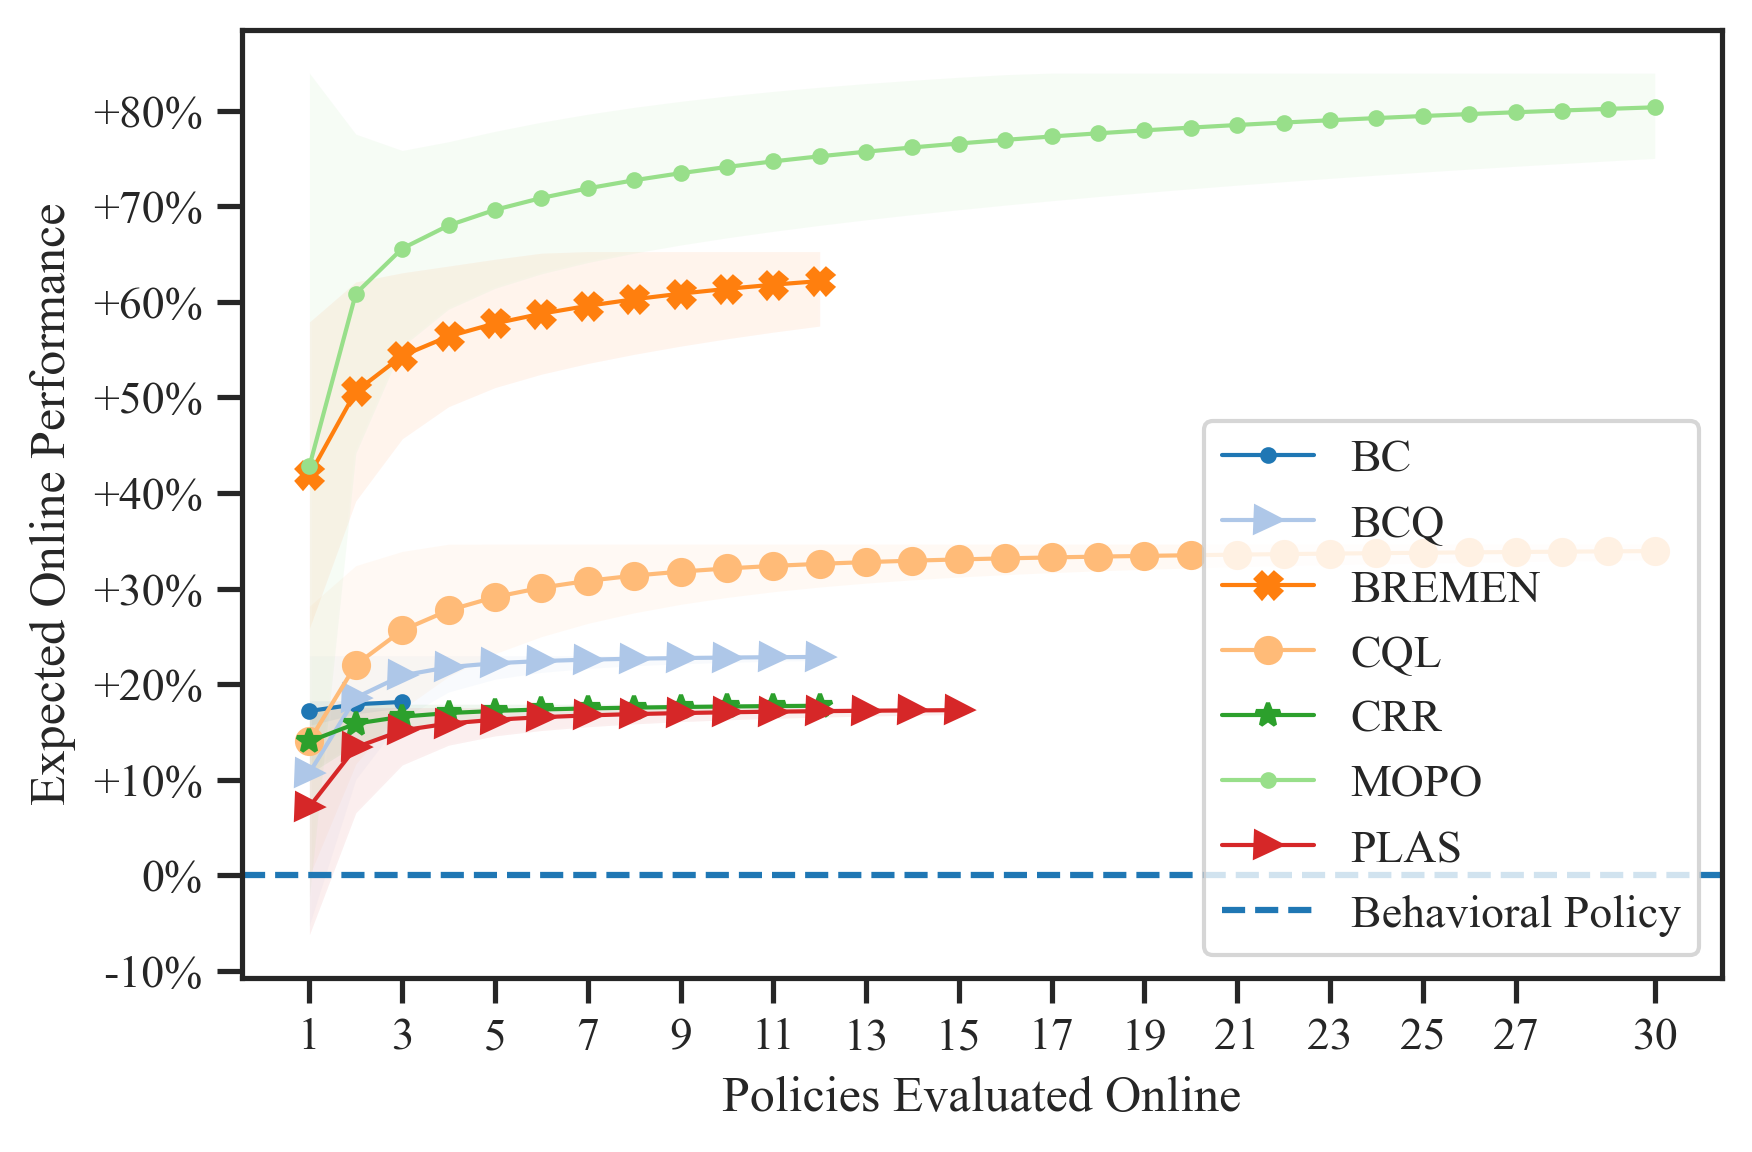

low 1000


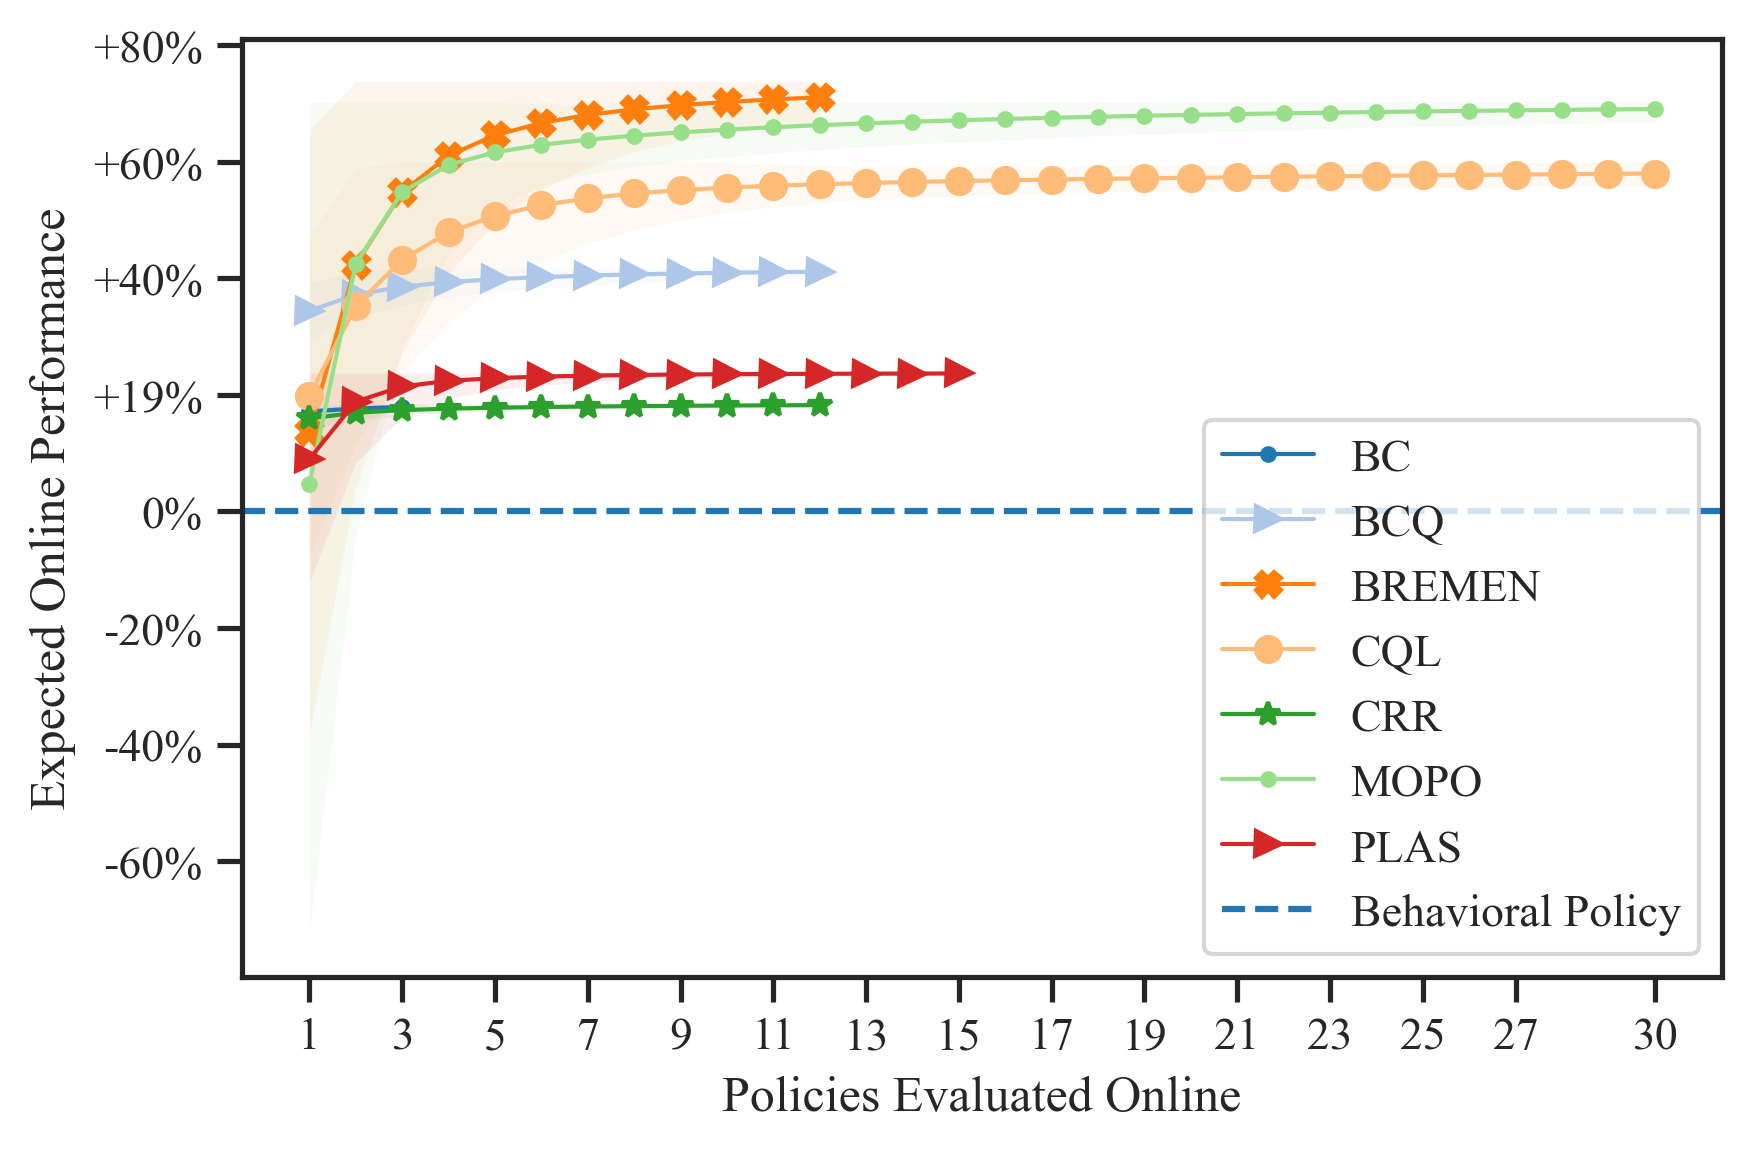

low 10000


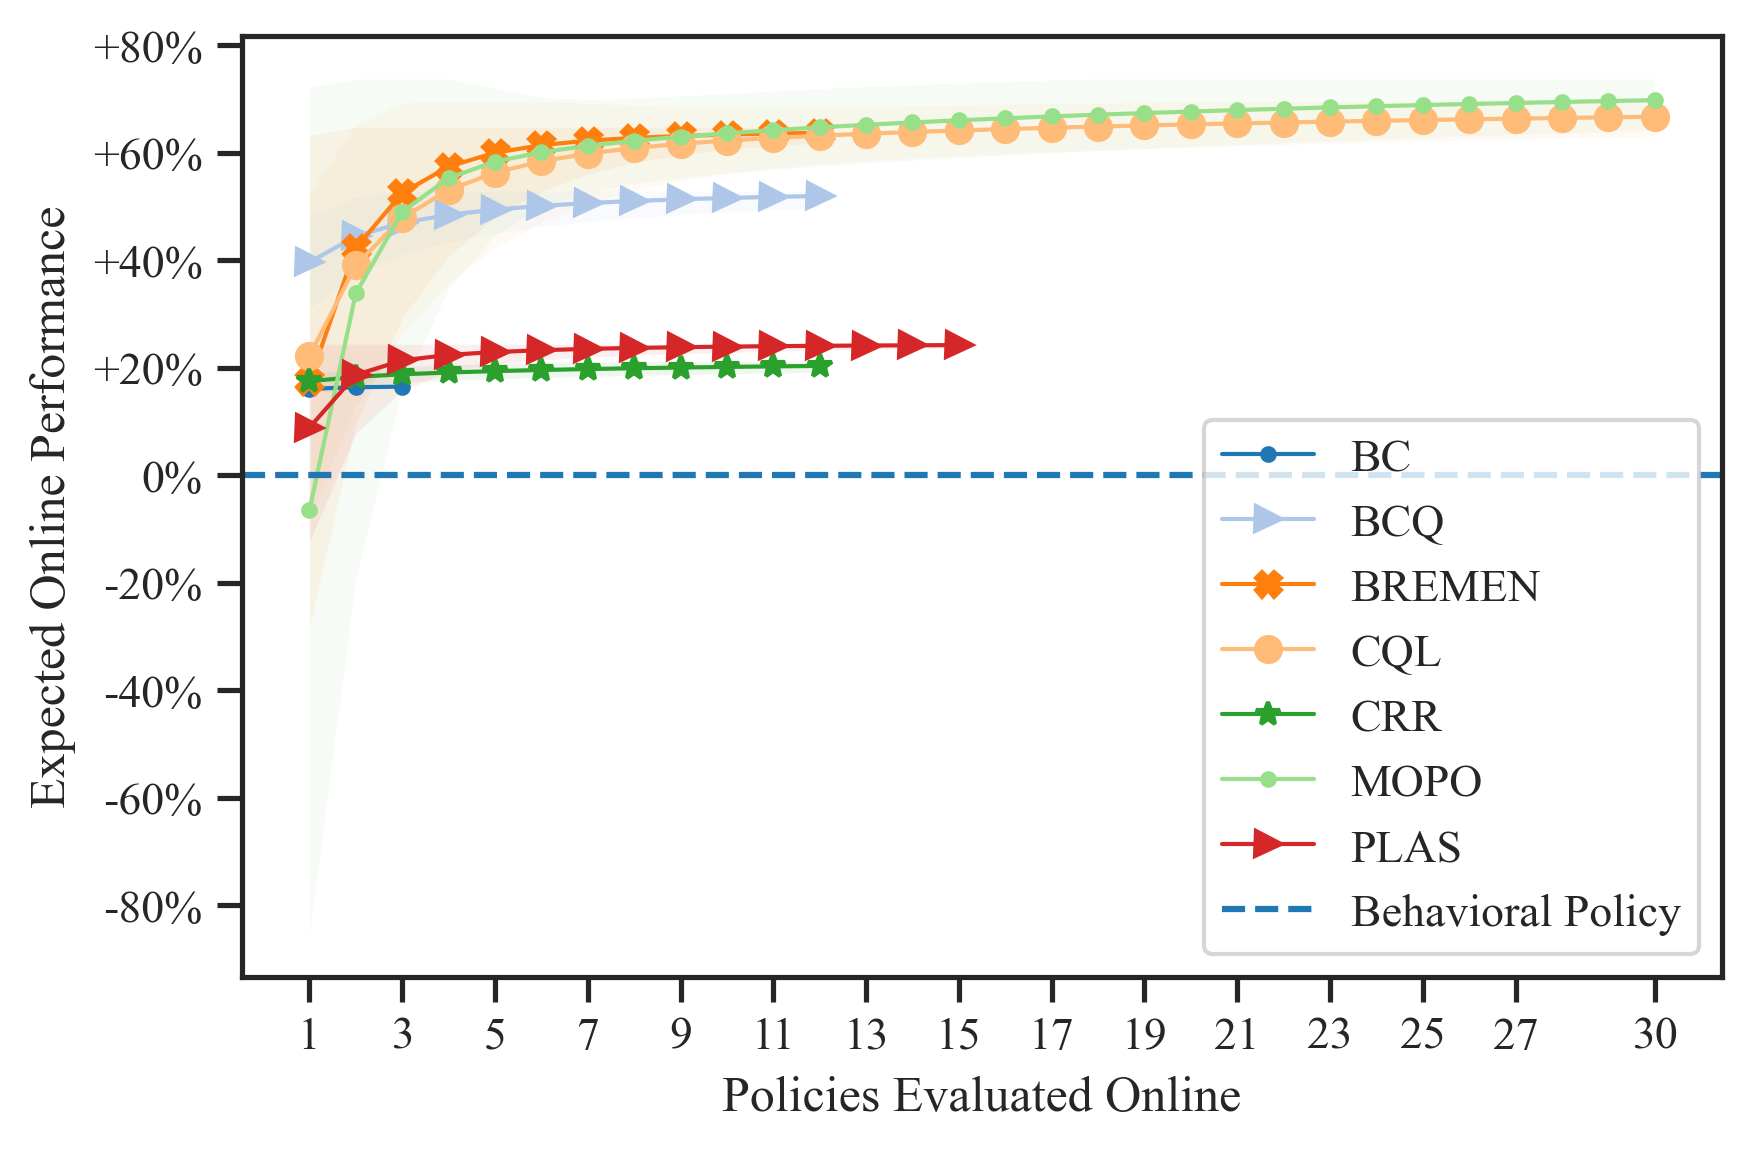

medium 100


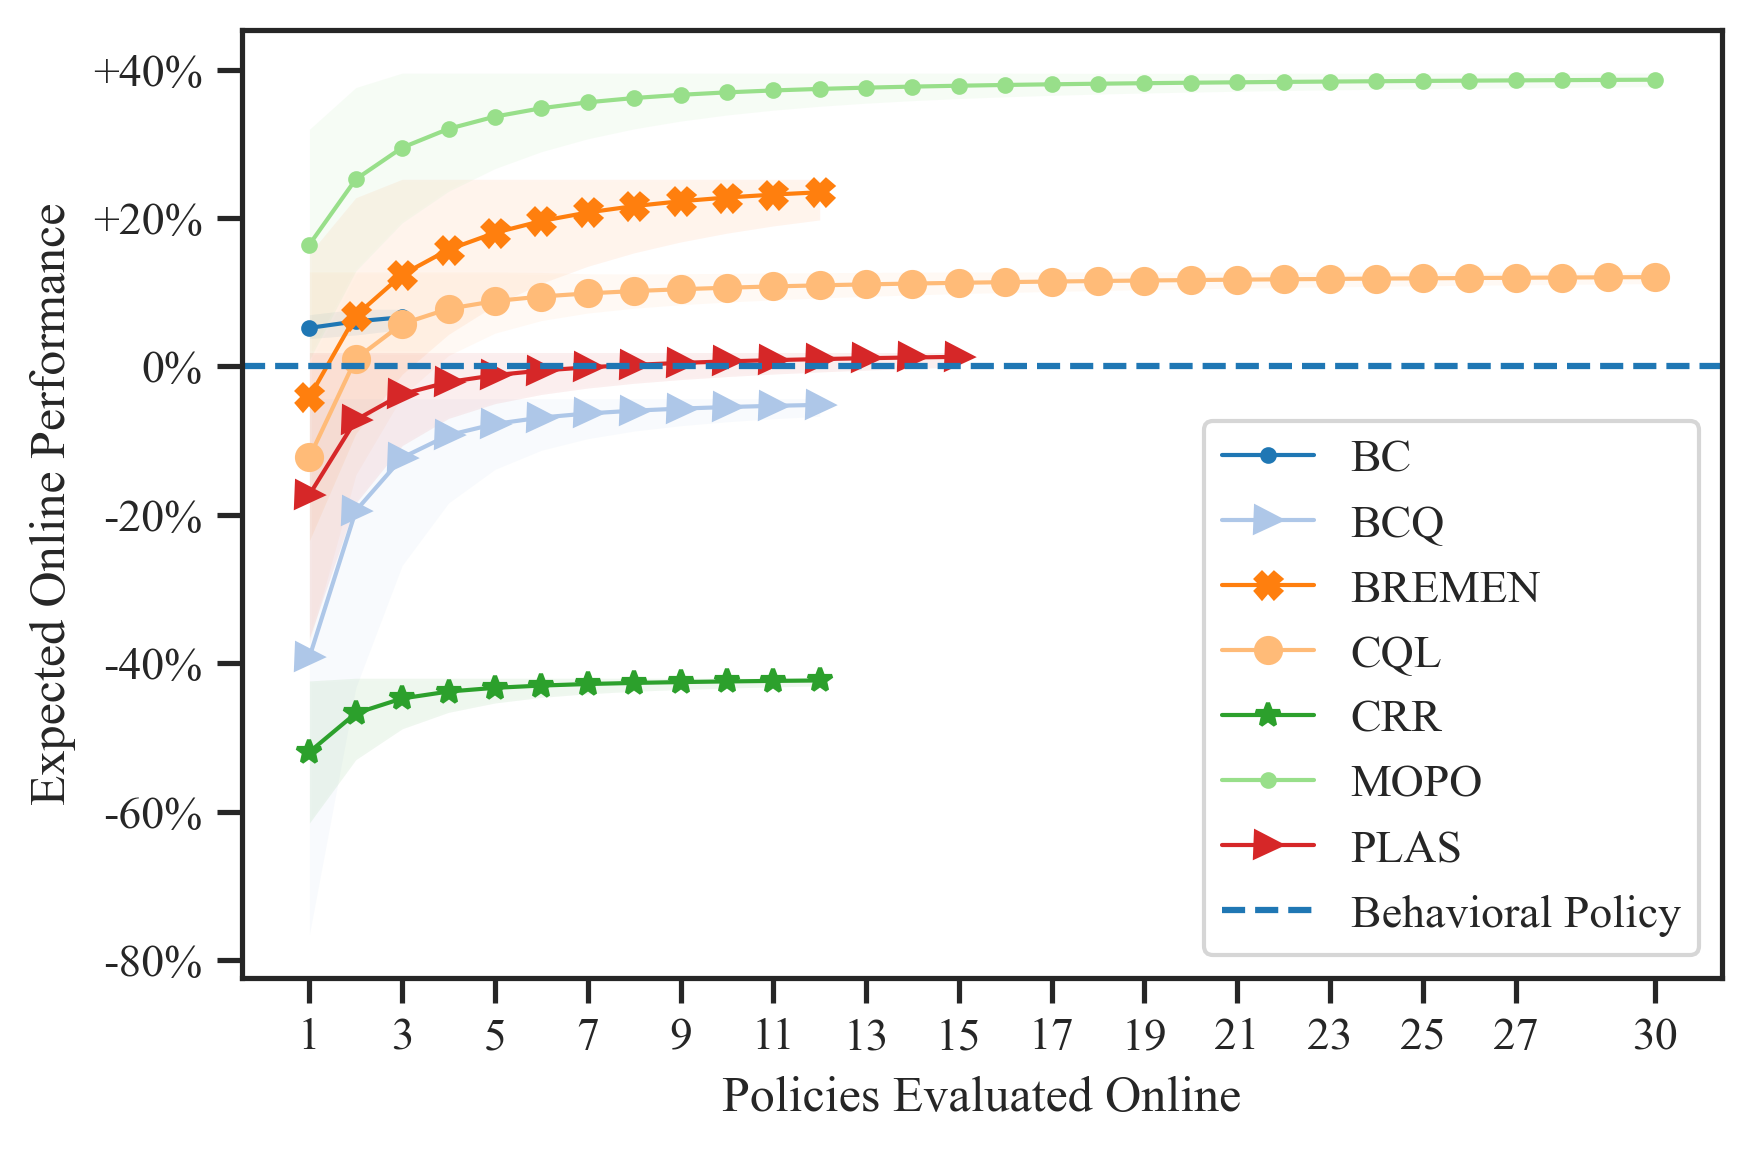

medium 1000


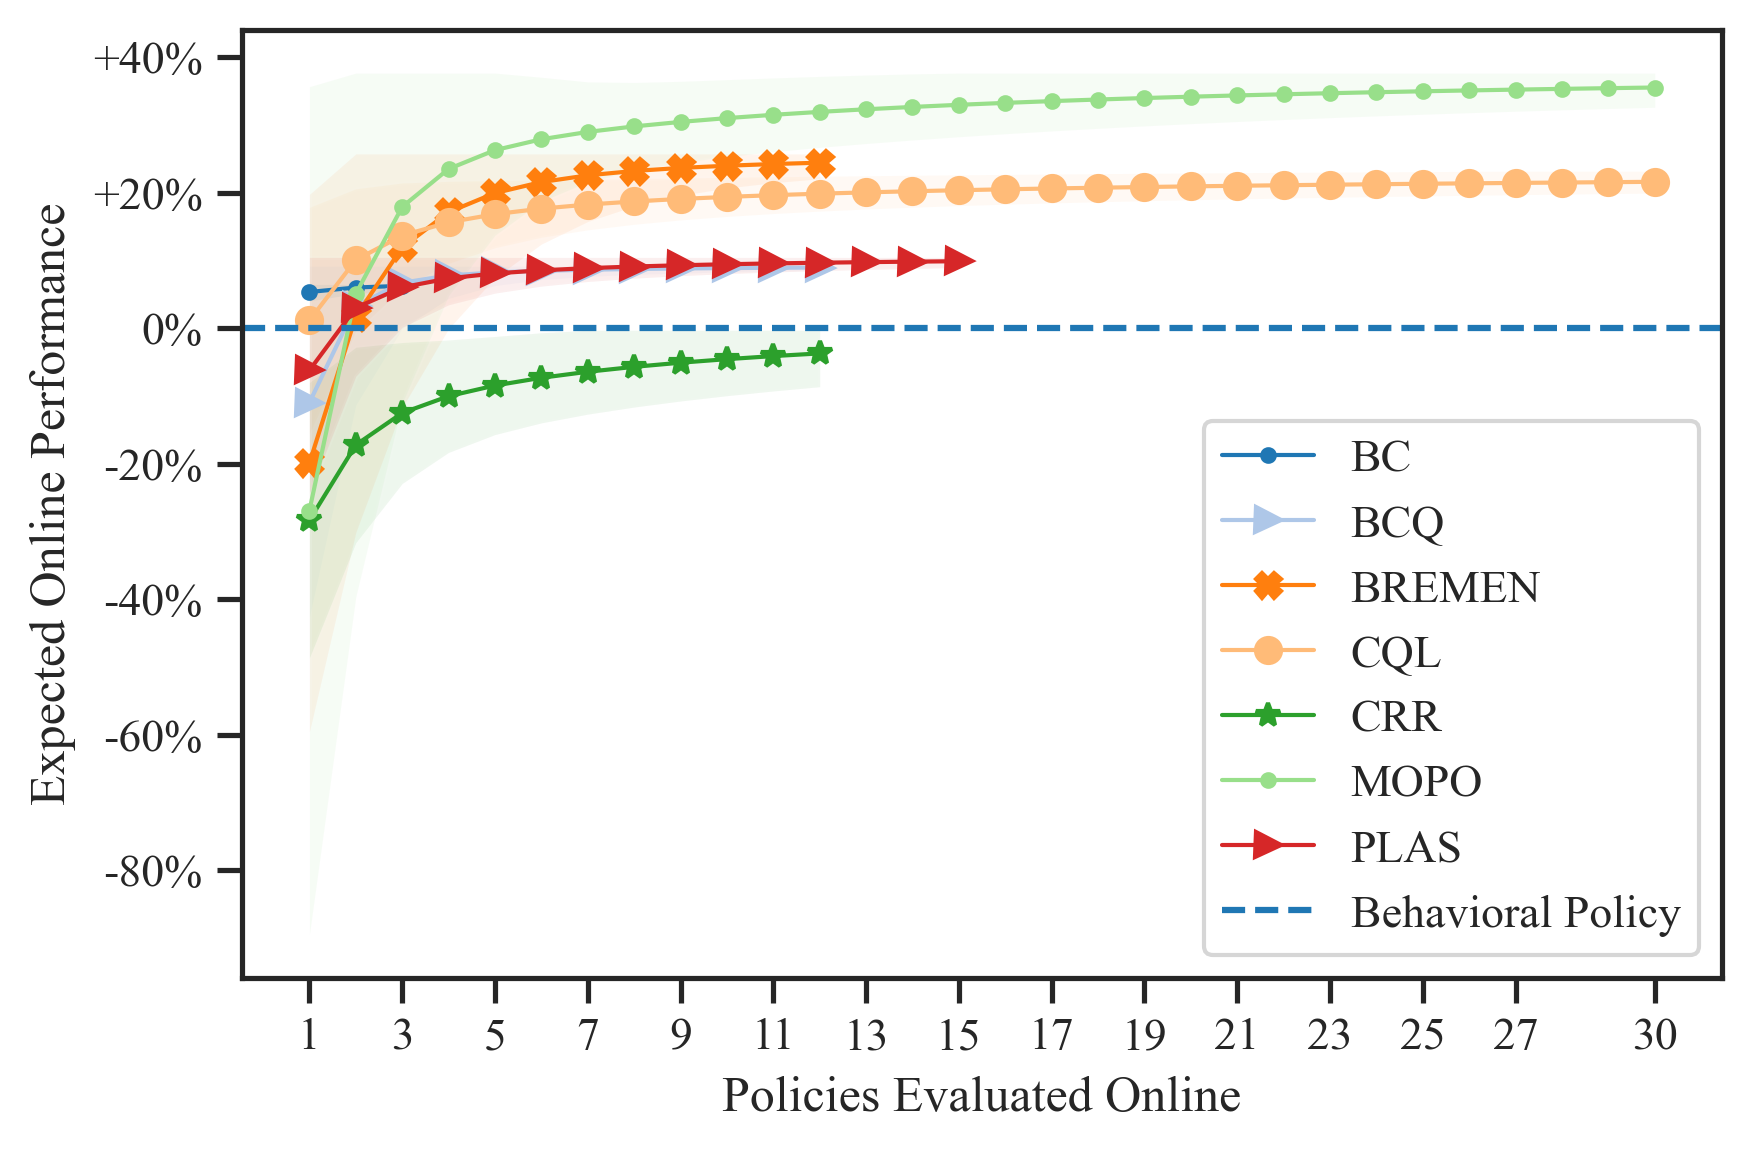

medium 10000


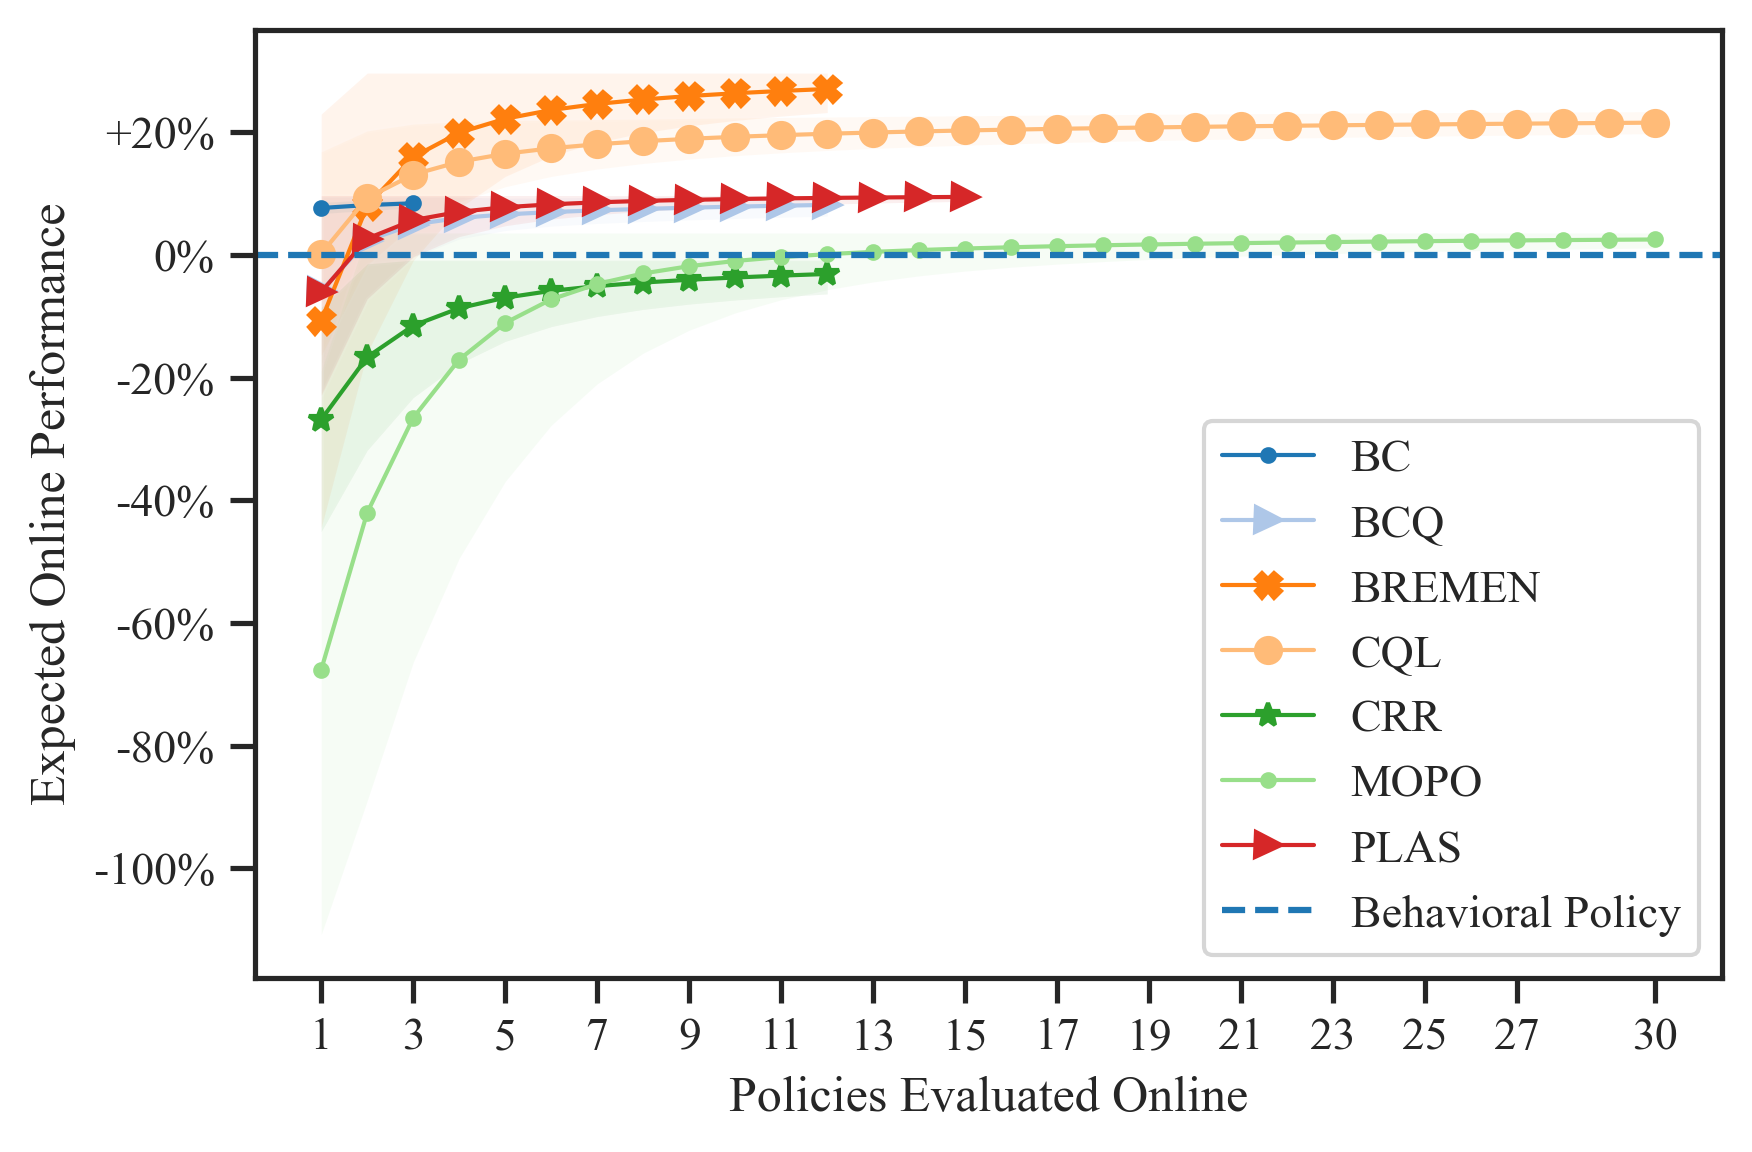

high 100


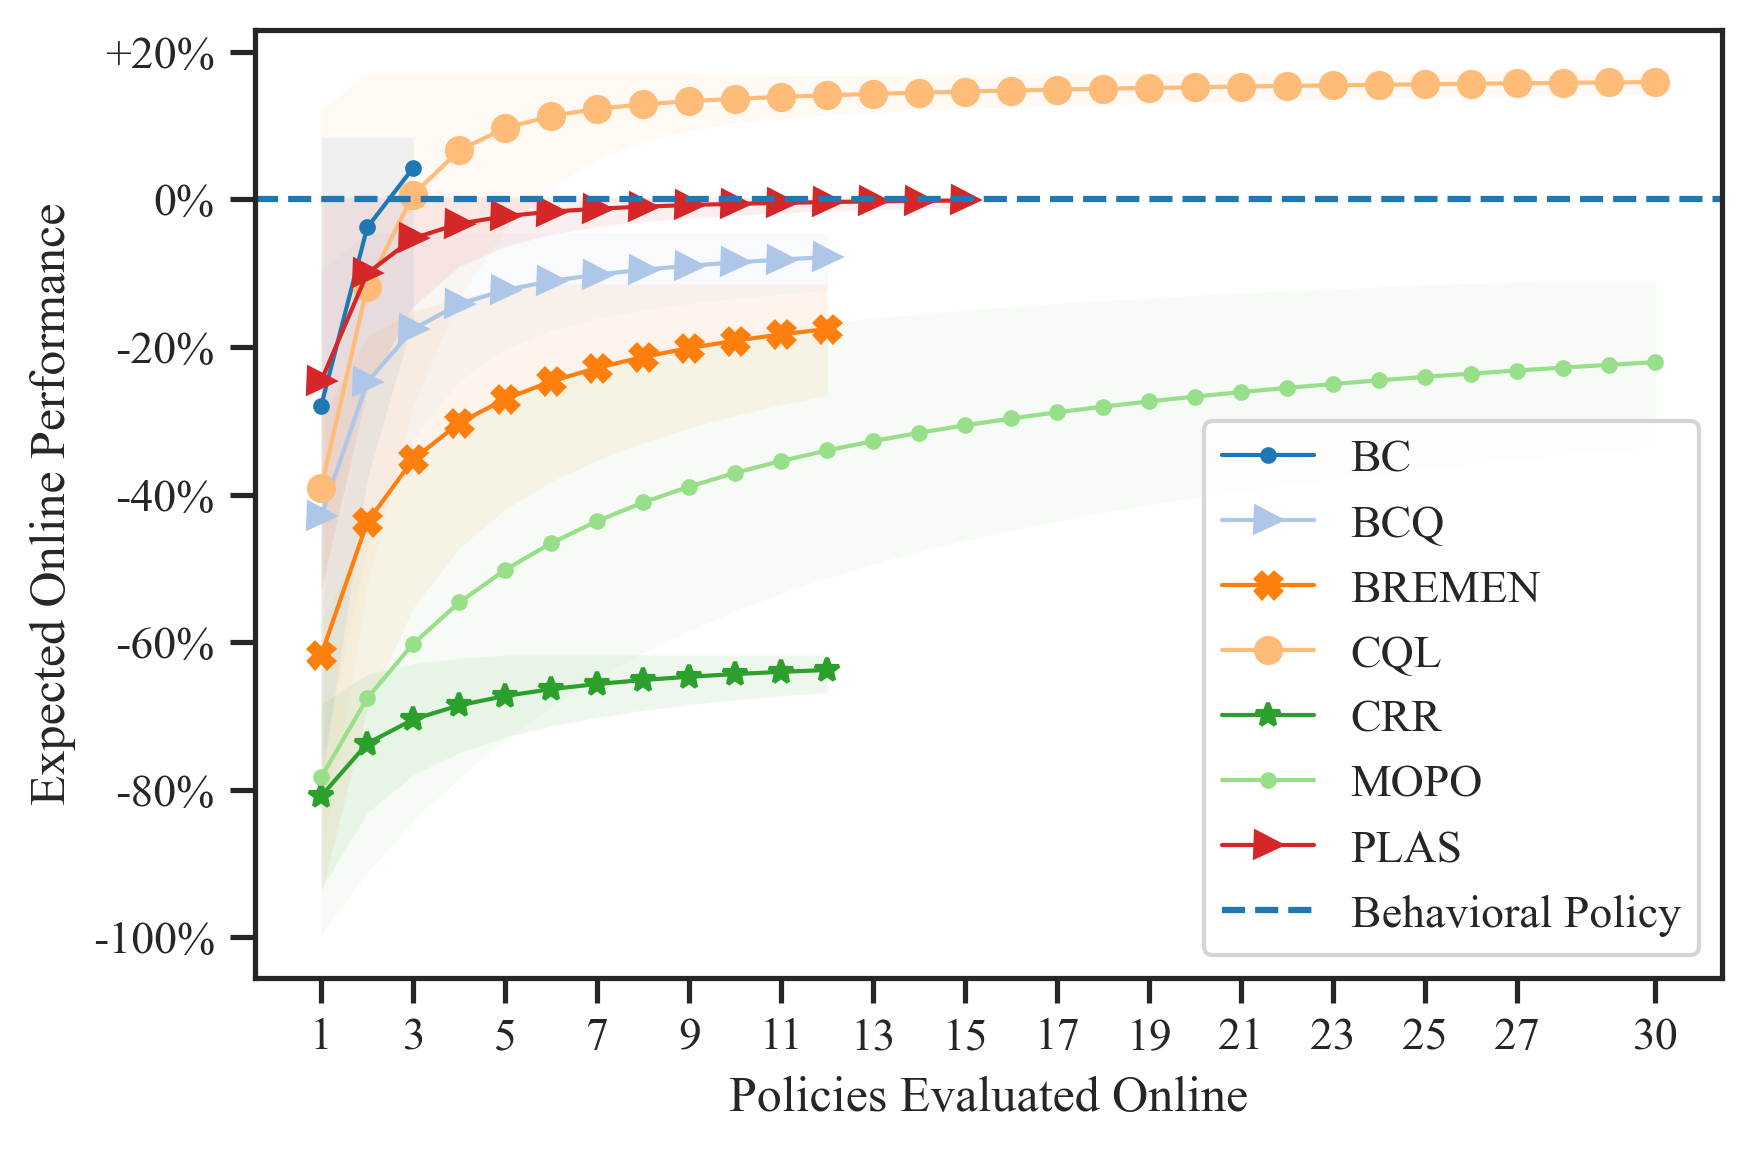

high 1000


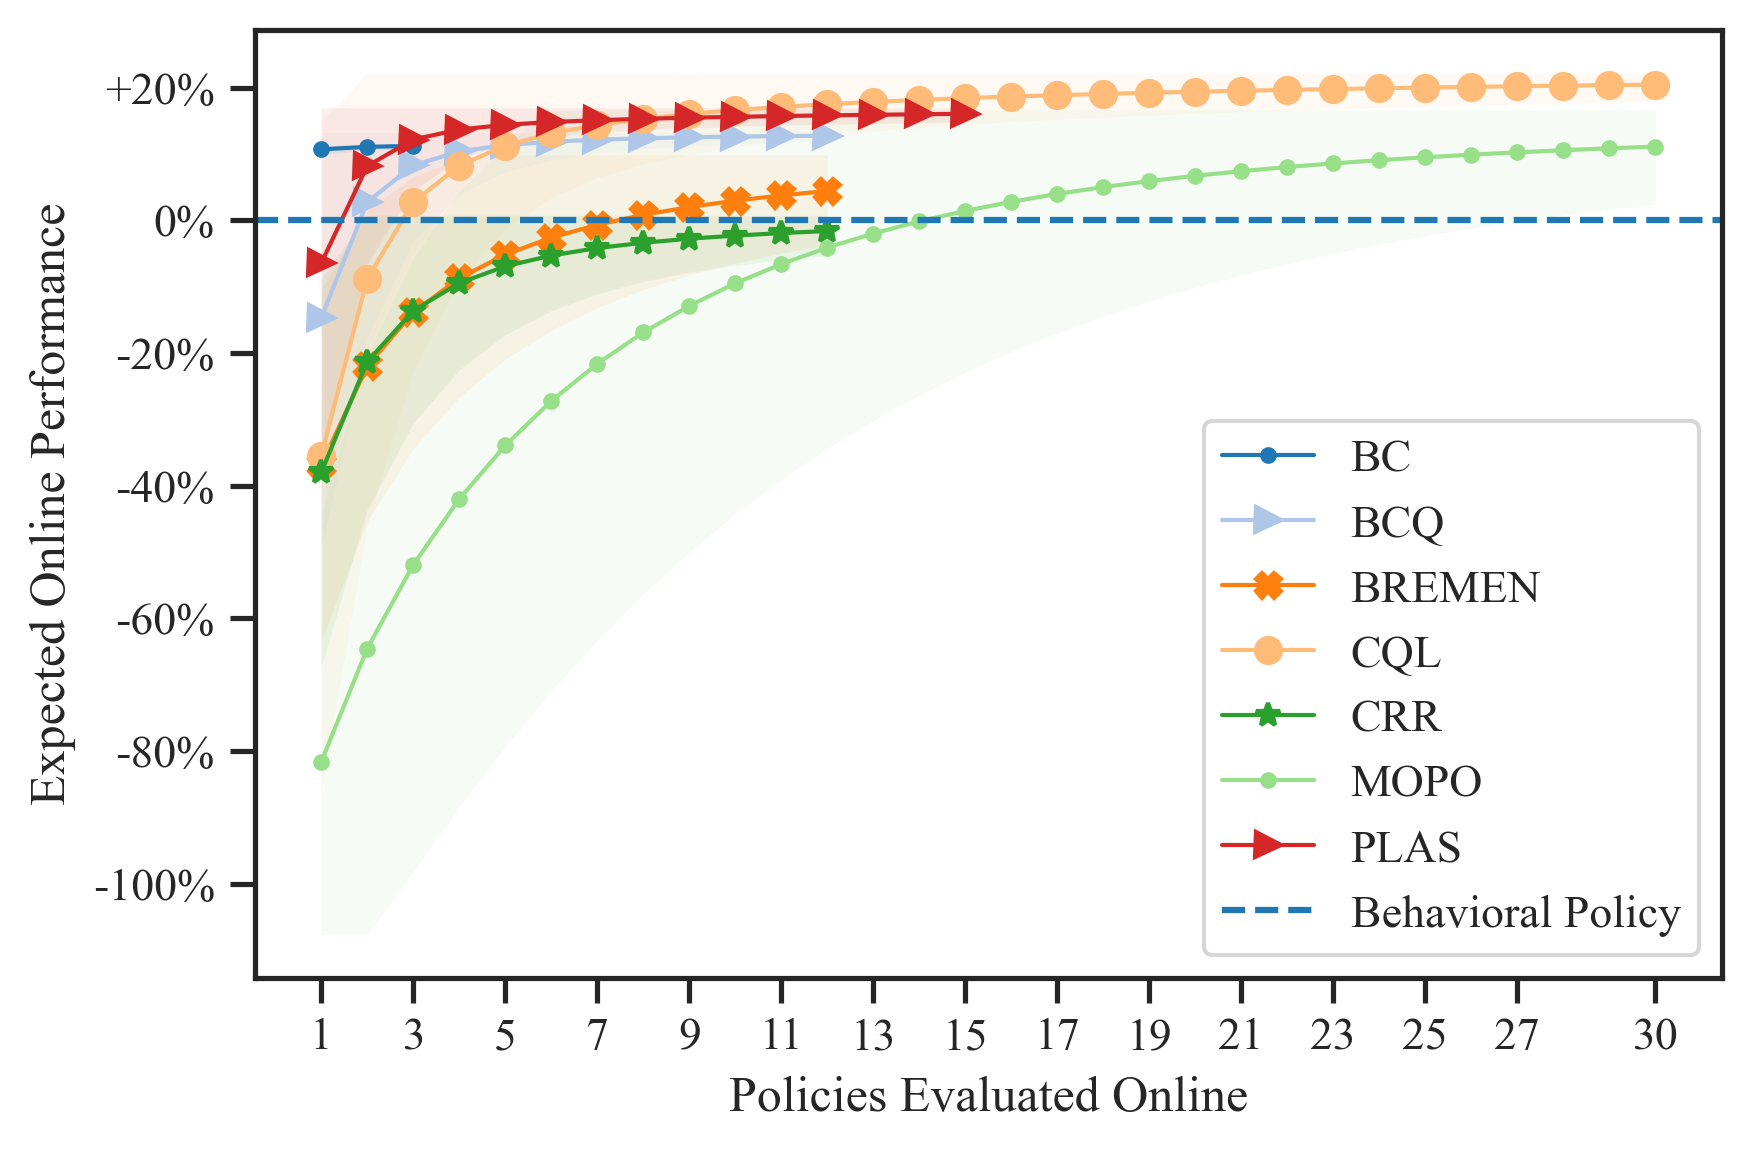

high 10000


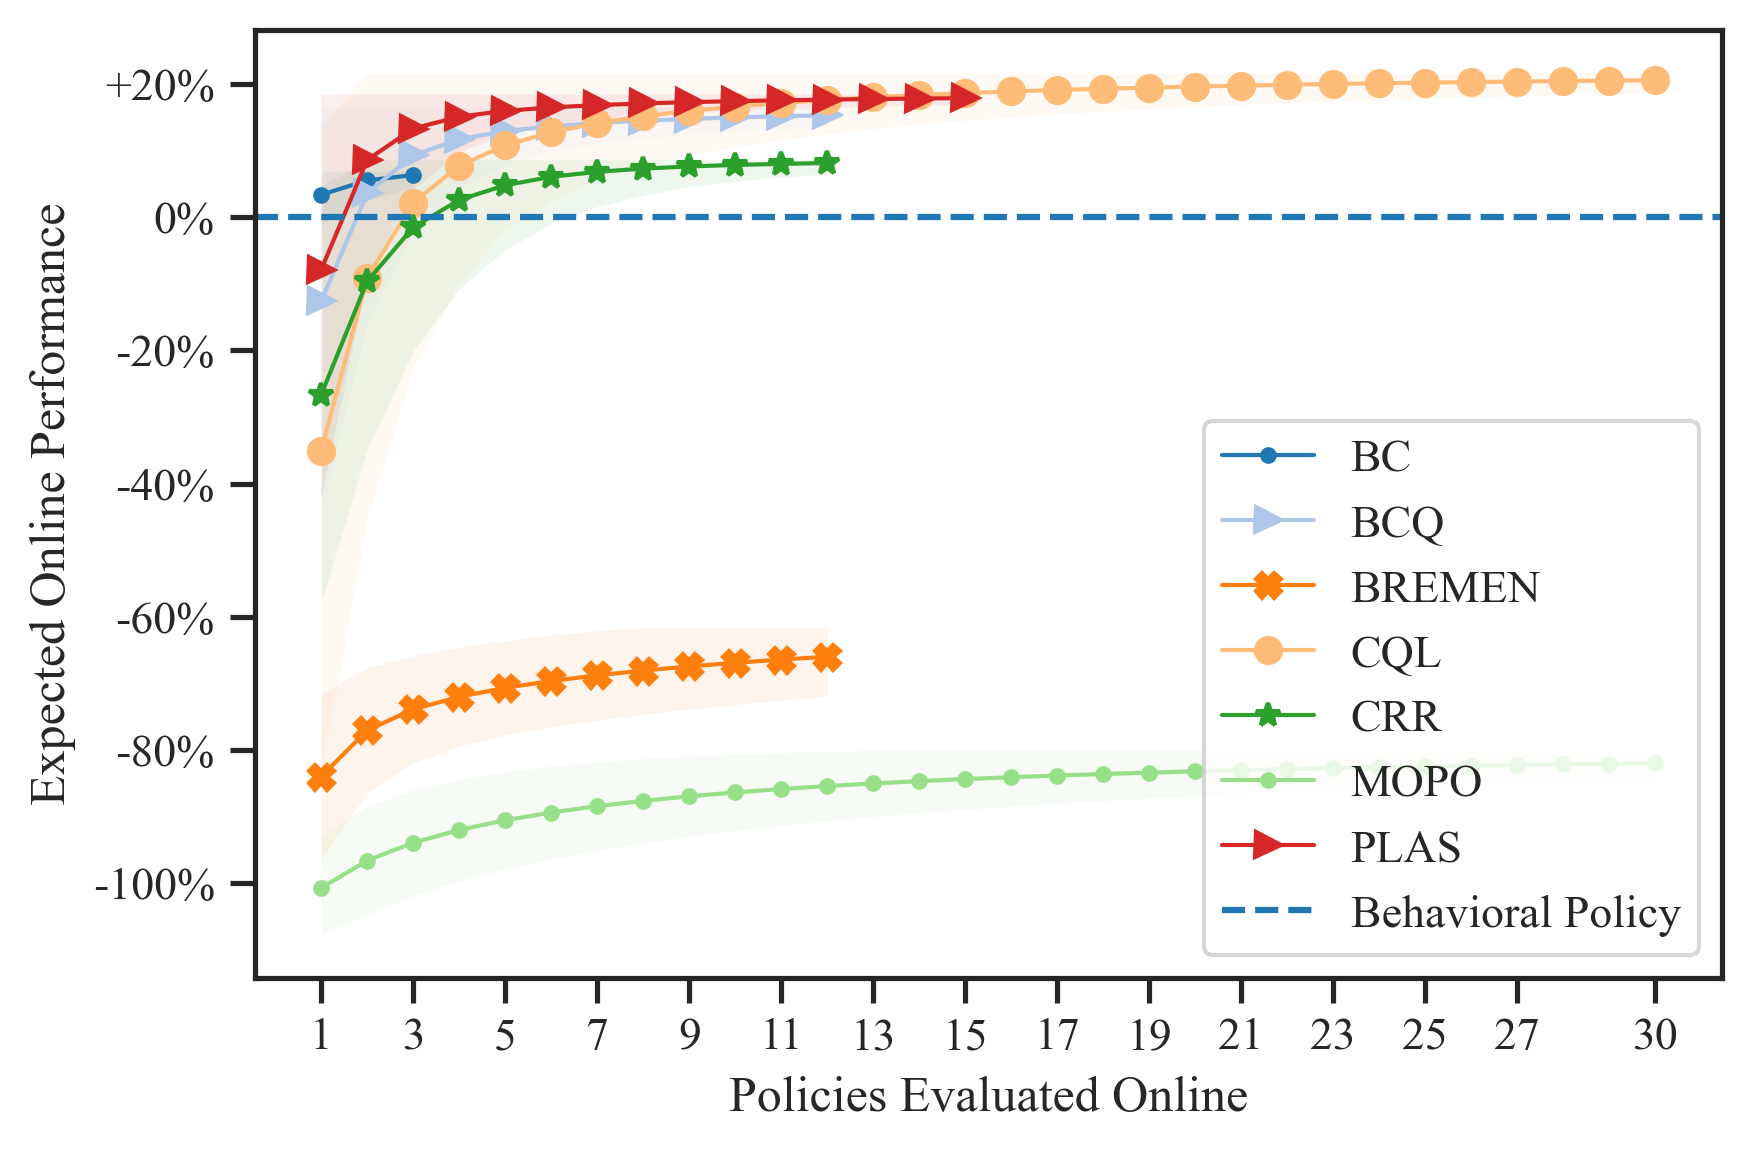

In [22]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

sns.set_palette("tab20")

TARGET_TRIALS = 30
for levels, trajs in product(["low", "medium", "high"], [100, 1000, 10000]):
    # 'HalfCheetah-v3', 'Hopper-v3', 'Walker2d-v3'
    env = "HalfCheetah-v3"
    cur_mask = (all_experiments.policy_level == levels) & (all_experiments.n_trajectories == trajs) & (all_experiments.ops_name == "uniform") & (all_experiments.env == env)
    explore_experiments = all_experiments[cur_mask]
    # OPS Labels
    labels = {
        "uniform": "Uniform",
        "val_vs0_q": "$V(s_{0})$ using Critic",
        "val_vs0_fqe": "$V(s_{0})$ using FQE",
        "val_tderror": "TD-Error",
        "val_loss": "Action Difference",
    }

    # Draw
    h3_grid = explore_experiments.groupby(["alg", "eop_ind"]).agg({
        "eop_mean": "mean",
        "eop_std": "mean",
        "eop_max": "max",
        "eop_min": "min"
    })
    # to set default values
    marker         = cycle(('.', '>', 'X', 'o', '*')) 
    linewidth      = 1
    errorbar_kind  = "shade"
    errorbar_alpha = 0.08
    fontsize       = 12

    _, cur_ax = plt.subplots(1,1)
    cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
    cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

    for n_trajectories, datapoints in h3_grid.groupby(["alg"]):
        means = datapoints["eop_mean"][:TARGET_TRIALS]
        vars  = datapoints["eop_std"][:TARGET_TRIALS]
        max_acc = max(datapoints["eop_max"])
        min_acc = min(datapoints["eop_min"])
        x_axis = [i+1 for i in range(len(means))]
        if True:
            if errorbar_kind == 'shade':
                minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
                plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
                plt.fill_between(x_axis,
                                 minus_vars,
                                 plus_vars,
                                 alpha=errorbar_alpha)
            else:
                cur_ax.errorbar(x_axis,
                                means,
                                yerr=vars,
                                linestyle=linestyle,
                                linewidth=linewidth)
        cur_ax.plot(x_axis,
                    means,
                    marker=next(marker),
                    linewidth=linewidth,
                    label=f"{str.upper(n_trajectories)}"
                   )
        
        # NeoRL performance
#         if n_trajectories == "cql":
#             percent = get_neorl_percent(alg=n_trajectories, env=env, level=levels, traj=trajs)
#             plt.axhline(percent, linestyle="dashed", linewidth=2)

    left, right = cur_ax.get_xlim()

    # Draw baseline performance
    plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral Policy")
    

    # Draw x axis
    plt.xlim((left, right))
#     plt.ylim(bottom=0.7)
    plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [30])

    # Draw y axis (improvement percent?)
    from math import floor
    def improvement_ticks(y, pos):
        improvement = floor((y - 1.0) * 100)
        if improvement > 0:
            return f"+{improvement}%"
        else:
            return f"{improvement}%"
#     plt.ylim((0.7, 1.60))
    cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

    plt.locator_params(axis='y', nbins=10)
    plt.tight_layout()
    plt.legend(loc="lower right")
    plt.savefig(f"{env}_{trajs}_{levels}_uniform.pdf")
    print(levels, trajs)
    plt.show()